#Introduction to Machine Learning
##Final Project by Josh Trivedi

## Import all the required libraries

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt 
from datetime import datetime
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from tabulate import tabulate

### Importing the data

In [2]:
waveforms = pd.read_csv('waveform.data', header=None, sep=',')
waveforms.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-1.23,-1.56,-1.75,-0.28,0.60,2.22,0.85,0.21,-0.20,0.89,...,2.89,7.75,4.59,3.15,5.12,3.32,1.20,0.24,-0.56,2
1,-0.69,2.43,0.61,2.08,2.30,3.25,5.52,4.55,2.97,2.22,...,1.24,1.89,1.88,-1.34,0.83,1.41,1.78,0.60,2.42,1
2,-0.12,-0.94,1.29,2.59,2.42,3.55,4.94,3.25,1.90,2.07,...,2.50,0.12,1.41,2.78,0.64,0.62,-0.01,-0.79,-0.12,0
3,0.86,0.29,2.19,-0.02,1.13,2.51,2.37,5.45,5.45,4.84,...,2.58,1.40,1.24,1.41,1.07,-1.43,2.84,-1.18,1.12,1
4,1.16,0.37,0.40,-0.59,2.66,1.00,2.69,4.06,5.34,3.53,...,4.30,1.84,1.73,0.21,-0.18,0.13,-0.21,-0.80,-0.68,1


In [3]:
# separate the data into features and labels
x = waveforms.drop(columns=[21])
y = waveforms[21]

In [4]:
# Split the data into training and testing sets
testdatai = waveforms.sample(1000).index
testdatav = waveforms.loc[testdatai]
data = waveforms.drop(index=testdatai)
xTrain = data.drop(columns=[21])
yTrain = data[21]
xTest = testdatav.drop(columns=[21])
yTest = testdatav[21]

## Tune in the best k of a kNN Classifier by cross-validation

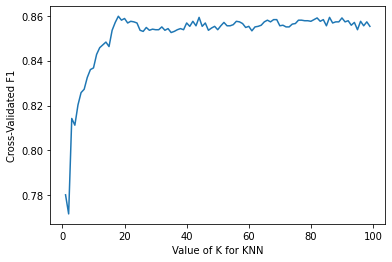

0.85975
Maximum accuracy 0.85975 with k=18


<Figure size 432x288 with 0 Axes>

In [5]:
%matplotlib inline
# range of k values to test
kRange = range(1, 100)
# list to store the average F1 score for each value of k
kScores = []
# use 10-fold cross-validation with each value of k
for k in kRange:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, xTrain, yTrain, cv=10, scoring='accuracy')
    kScores.append(scores.mean())

# plot the value of k for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(kRange, kScores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated F1')
plt.show()
# examine the best F1 score
print(max(kScores))
# examine the corresponding optimal k value
print("Maximum accuracy "+str(max(kScores))+" with k="+str(kRange[kScores.index(max(kScores))]))
# export the graph
plt.savefig('knn.png')
# prepare the table
table = pd.DataFrame({'k':kRange, 'F1':kScores})
table.to_csv('knn.csv', index=False)

## Reducing the complexity
Data Reduction Algorithms

Accuracy before data reduction:  0.79
Accuracy after data reduction:  0.801
Number of good samples:  563
Final Accuracy:  0.747


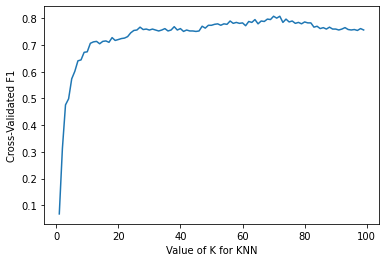

<Figure size 432x288 with 0 Axes>

In [8]:
# 1NN Classifier
knn = KNeighborsClassifier(n_neighbors=1, algorithm="brute")
knn.fit(xTrain, yTrain)
# Compute the accuracy of the model
print('Accuracy before data reduction: ', knn.score(xTest, yTest))
x1, x2, y1, y2 = train_test_split(xTrain, yTrain, test_size=0.5, random_state=1)
knn_cleaning = KNeighborsClassifier(n_neighbors=1, algorithm="brute")
flag = True
# Data Reduction by dropping the misclassified samples
while flag:
    x1.reset_index(drop=True, inplace=True)
    x2.reset_index(drop=True, inplace=True)
    y1.reset_index(drop=True, inplace=True)
    y2.reset_index(drop=True, inplace=True)
    initial = len(y1) + len(y2)

    knn_cleaning.fit(x2, y2)
    prediction = knn_cleaning.predict(x1)
    dropList = []
    for i in range(len(prediction)):
        if prediction[i] != y1[i]:
            dropList.append(i)
    x1.drop(index=dropList, inplace=True)
    y1.drop(index=dropList, inplace=True)

    
    knn_cleaning.fit(x1, y1)
    prediction = knn_cleaning.predict(x2)
    dropList = []
    for i in range(len(prediction)):
        if prediction[i] != y2[i]:
            dropList.append(i)
    x2.drop(index=dropList, inplace=True)
    y2.drop(index=dropList, inplace=True)

    if len(y1) + len(y2) == initial:
        flag = False

newX = pd.concat([x1, x2], ignore_index=True, axis=0)
newY = pd.concat([y1, y2], ignore_index=True, axis=0)
knn = KNeighborsClassifier(n_neighbors=1, algorithm="brute")
knn.fit(newX, newY)
print('Accuracy after data reduction: ', knn.score(xTest, yTest))
# Checking number of good samples
flag = True
goodOnes = []
goodOnes.append(random.randint(0,len(newY)))
while flag:
    flag = False
    for i in newX.index:
        if i in goodOnes:
            goodOnes.remove(i)
            knn_cleaning.fit(newX.loc[goodOnes], newY.loc[goodOnes])
            goodOnes.append(i)
        else:
            knn_cleaning.fit(newX.loc[goodOnes], newY.loc[goodOnes])
        if knn_cleaning.predict([newX.loc[i]])[0] != newY.loc[i]:
            if i not in goodOnes:
                goodOnes.append(i)
                flag = True
        else:
            if i in goodOnes:
                goodOnes.remove(i)
                flag = True
        

print('Number of good samples: ', len(goodOnes))
knn = KNeighborsClassifier(n_neighbors=1, algorithm="brute")
knn.fit(newX.loc[goodOnes], newY.loc[goodOnes])
print('Final Accuracy: ', knn.score(xTest, yTest))

#plot the new graph
kRange = range(1, 100)
# list to store the average F1 score for each value of k
kScores = []
# use 10-fold cross-validation with each value of k
for k in kRange:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, newX.loc[goodOnes], newY.loc[goodOnes], cv=10, scoring='accuracy')
    kScores.append(scores.mean())


# plot the value of k for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(kRange, kScores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated F1')
plt.show()
# export the graph
plt.savefig('knn2.png')

# prepare the table
table = pd.DataFrame({'k':kRange, 'F1':kScores})
table.to_csv('knn2.csv', index=False)

## Speeding up the Calculation 

KD Tree Training time:  0.031598
KD Tree Testing time:  0.278134
Ball Tree Training time:  0.012976
Ball Tree Testing time:  0.194683
Brute Force Training time:  0.003987
Brute Force Testing time:  0.119298


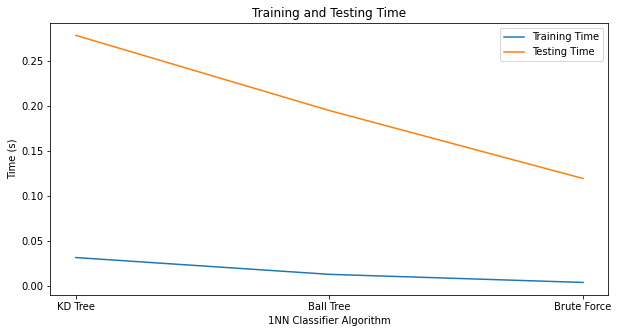

AttributeError: 'str' object has no attribute 'to_csv'

In [7]:
#Speeding up the calculation of the 1NN classifier
# by using the KDTree algorithm
knn = KNeighborsClassifier(n_neighbors=1, algorithm="kd_tree")
start = datetime.now()
knn.fit(xTrain, yTrain)
end = datetime.now()
kd_training_time = (end-start).total_seconds()
print('KD Tree Training time: ', (end-start).total_seconds())

start = datetime.now()
knn.score(xTest, yTest)
end = datetime.now()
kd_testing_time = (end-start).total_seconds()
print('KD Tree Testing time: ', (end-start).total_seconds())

#by using the BallTree algorithm
knn = KNeighborsClassifier(n_neighbors=1, algorithm="ball_tree")
start = datetime.now()
knn.fit(xTrain, yTrain)
end = datetime.now()
bt_training_time = (end-start).total_seconds()
print('Ball Tree Training time: ', (end-start).total_seconds())

start = datetime.now()
knn.score(xTest, yTest)
end = datetime.now()
bt_testing_time = (end-start).total_seconds()
print('Ball Tree Testing time: ', (end-start).total_seconds())

#by using the brute force algorithm
knn = KNeighborsClassifier(n_neighbors=1, algorithm="brute")
start = datetime.now()
knn.fit(xTrain, yTrain)
end = datetime.now()
bf_training_time = (end-start).total_seconds()
print('Brute Force Training time: ', (end-start).total_seconds())

start = datetime.now()
knn.score(xTest, yTest)
end = datetime.now()
bf_testing_time = (end-start).total_seconds()
print('Brute Force Testing time: ', (end-start).total_seconds())


# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(['KD Tree', 'Ball Tree', 'Brute Force'], [kd_training_time, bt_training_time, bf_training_time], label='Training Time')
plt.plot(['KD Tree', 'Ball Tree', 'Brute Force'], [kd_testing_time, bt_testing_time, bf_testing_time], label='Testing Time')
plt.legend()
plt.title('Training and Testing Time')
plt.xlabel('1NN Classifier Algorithm')
plt.ylabel('Time (s)')
plt.show()

# Export the table
table = (tabulate([['KD Tree', kd_training_time, kd_testing_time], ['Ball Tree', bt_training_time, bt_testing_time], ['Brute Force', bf_training_time, bf_testing_time]], headers=['Algorithm', 'Training Time (s)', 'Testing Time (s)']))
table.to_csv('three.csv', index=False)


## Generating Artificial Imbalance 

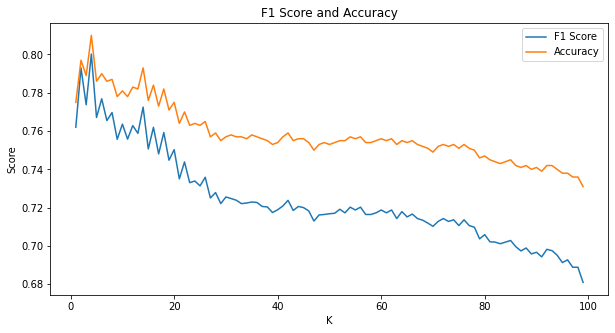

In [ ]:
totalDataCount = data[data[21]==0].shape[0]
classIndexes = data[data[21]==0].sample(int(totalDataCount*0.8)).index
unbalanceData = data.drop(index=classIndexes)

xTrain = unbalanceData.drop(columns=[21])
yTrain = unbalanceData[21]

kRange = range(1, 100)
f1Scores = []
kScores = []
# use iteration to caclulator different k in models, then return the average accuracy and f1 score
for k in kRange:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm="brute")
    knn.fit(xTrain, yTrain)
    yPredict = knn.predict(xTest)
    f1Scores.append(f1_score(yTest, yPredict, average='weighted'))
    kScores.append(knn.score(xTest, yTest))

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(kRange, f1Scores, label='F1 Score')
plt.plot(kRange, kScores, label='Accuracy')
plt.legend()
plt.title('F1 Score and Accuracy')
plt.xlabel('K')
plt.ylabel('Score')
plt.show()

#export the data as a table
table = pd.DataFrame({'K': kRange, 'F1 Score': f1Scores, 'Accuracy': kScores})
print(table.to_string(index=False))
table.to_csv('four.csv', index=False)
